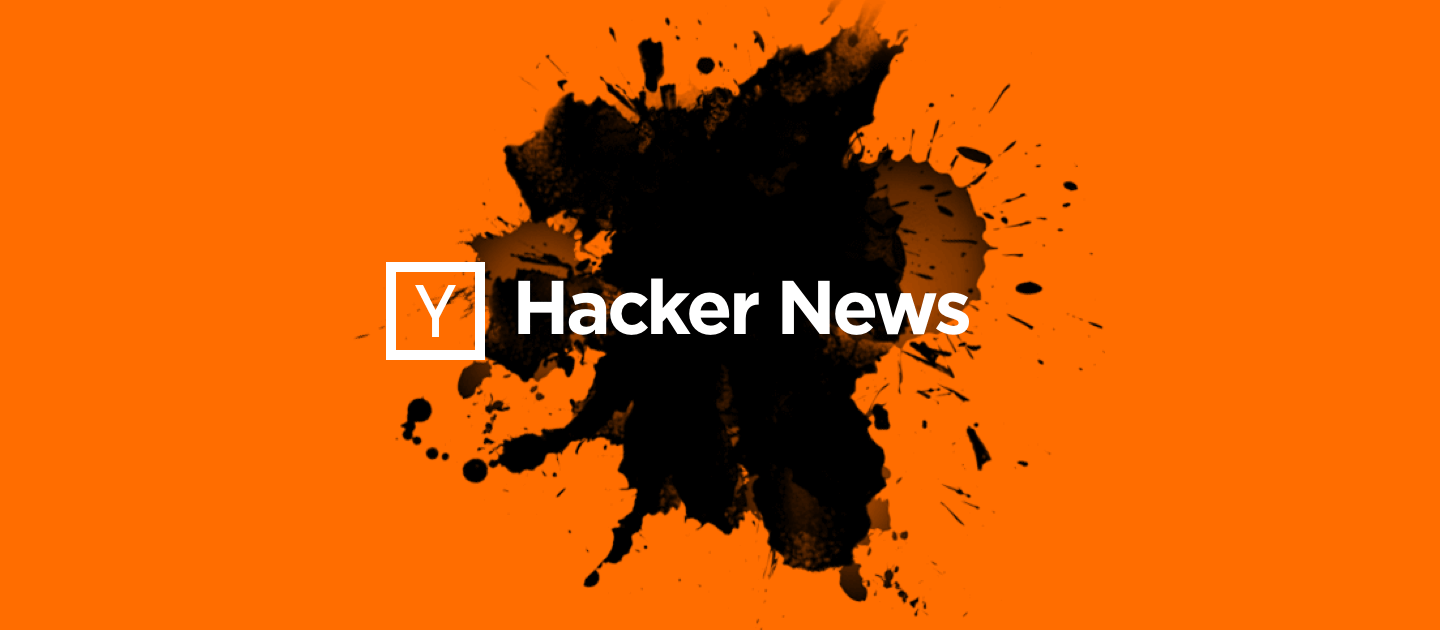



# Introduction
**[Hacker News](https://news.ycombinator.com/)** is a link aggregator website that users vote up stories that are interesting to the community. It is similar to Reddit, but the community only revolves around computer science and entrepreneurship posts. Like any social link aggregator site, individual users can post whatever content they want. Below is a screenshot of the Hacker News homepage:

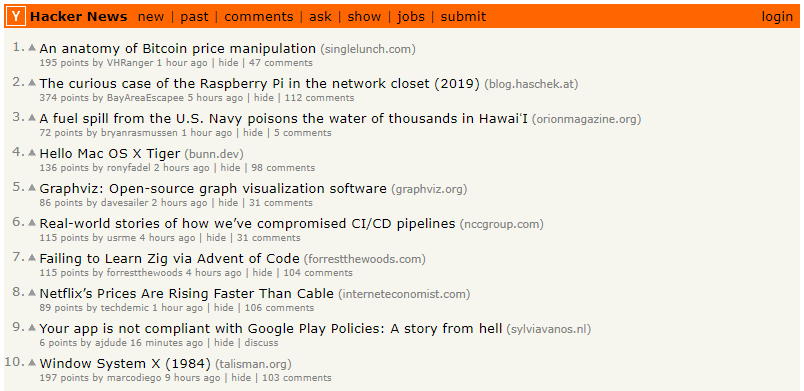


# Goal
In this project, we will use a data pipeline we've built in a separate python file and apply it to a real-world data pipeline project. Then, we will run a sequence of basic natural language processing tasks using our Pipeline class. The goal will be to find the most talked about tech topics in 2014 by finding the top 100 keywords of Hacker News posts.

# Data
We will use data from a Hacker News (HN) API that returns JSON data of the top stories in 2014. We have already downloaded a list of JSON posts called **hn_stories_2014.json**, and created the Pipeline class in **pipeline.py**. All files from this project can be cloned from this [github repository](https://github.com/gr3yw0rm/Dataquest-Showcases/tree/master/Hacker%20News%20Data%20Pipeline).

Each post has a set of keys, but we will deal only with the following keys:

* created_at: A timestamp of the story's creation time.
* created_at_i: A unix epoch timestamp.
* url: The URL of the story link.
* objectID: The ID of the story.
* author: The story's author (username on HN).
* points: The number of upvotes the story had.
* title: The headline of the post.
* num_comments: The number of a comments a post has.

Here's an example of the full list of keys in a story:

In [1]:
import json

with open('hn_stories_2014.json', 'r') as f:
    first_story = json.load(f)['stories'][0]
    print(json.dumps(first_story, indent=4))

{
    "story_text": "",
    "created_at": "2014-05-29T08:25:40Z",
    "story_title": null,
    "story_id": null,
    "comment_text": null,
    "created_at_i": 1401351940,
    "url": "https://duckduckgo.com/settings",
    "parent_id": null,
    "objectID": "7815290",
    "author": "TuxLyn",
    "points": 1,
    "title": "DuckDuckGo Settings",
    "_tags": [
        "story",
        "author_TuxLyn",
        "story_7815290"
    ],
    "num_comments": 0,
    "_highlightResult": {
        "story_text": {
            "matchedWords": [],
            "value": "",
            "matchLevel": "none"
        },
        "author": {
            "matchedWords": [],
            "value": "TuxLyn",
            "matchLevel": "none"
        },
        "url": {
            "matchedWords": [],
            "value": "https://duckduckgo.com/settings",
            "matchLevel": "none"
        },
        "title": {
            "matchedWords": [],
            "value": "DuckDuckGo Settings",
            "matchLevel

#### Instantiating Pipeline class

In [2]:
from pipeline import Pipeline

pipeline = Pipeline()

#### First task: Loading the JSON data
We'll start the project by loading the JSON file data into Python.

In [3]:
@pipeline.task()
def file_to_json():
    '''
    Loads JSON file into a Python dict.
    '''
    with open('hn_stories_2014.json', 'r') as f:
        stories = json.load(f)['stories']
    return stories

#### Second task: Filtering the Popular Stories
Now that we have loaded in all the stories as a list of dict objects, we can now operate on them. Let's start by filtering the list of stories to get the most popular stories of the year.

In [4]:
@pipeline.task(depends_on=file_to_json)
def filter_stories(stories):
    '''
    Filters popular stories that have more than 50 points, 
    more than 1 comment, and do not begin with Ask HN.
    '''
    popular_stories = [story for story in stories
                       if story['points'] > 50 
                           and story['num_comments'] > 1
                           and not story['title'].startswith('Ask HN')]
    return popular_stories

#### Third task: Converting to CSV
With a reduced set of stories, it's time to write these dict objects to a CSV file.

In [5]:
import io
import datetime as dt
from pipeline import build_csv

@pipeline.task(depends_on=filter_stories)
def json_to_csv(stories):
    lines = []
    for story in stories:
        lines.append(
            (story['objectID'], dt.datetime.strptime(story['created_at'], "%Y-%m-%dT%H:%M:%SZ"), 
             story['url'], story['points'], story['title'])
        )
    csv_file = build_csv(lines, header=['objectID', 'created_at', 'url', 'points', 'title'], 
                         file=io.StringIO())
    return csv_file

#### Fourth task: Extracting Title Column
Using the CSV file format we created in the previous task, we can now extract the title column. Once we have extracted the titles of each popular post, we can then run the next word frequency task

In [6]:
import csv

@pipeline.task(depends_on=json_to_csv)
def extract_titles(csv_file):
    reader = csv.reader(csv_file)
    header = next(reader)
    index  = header.index('title') # index of the title column
    lines  = [line[index] for line in reader]
    return lines

#### Fifth  task: Cleaning the Titles
To clean the titles, we should make sure to lower case the titles, and to remove the punctuation.

In [7]:
import string

@pipeline.task(depends_on=extract_titles)
def clean_title(titles):
    for title in titles:
        title = title.lower()
        title = ''.join(char for char in title if char not in string.punctuation)
        yield title

#### Fifth task: Creating the Word Frequency Dictionary
With a cleaned title, we can now build the word frequency dictionary. A word frequency dictionary are key value pairs that connects a word to the number of times it is used in a text. Furthermore, to find actual keywords, we should enforce the word frequency dictionary to not include **stop words**. Stop words are words that occur frequently in language like "the", "or", etc., and are commonly rejected in keyword searches. We have included a module called stop_words with a tuple of the most common used stop words in the English language.

In [8]:
from stop_words import stop_words

@pipeline.task(depends_on=clean_title)
def build_keyword_dictionary(titles):
    word_freq = {}
    for title in titles:
        for word in title.split(' '):
            if word and word not in stop_words:
                if word not in word_freq:
                    word_freq[word] = 1
                word_freq[word] += 1
    return word_freq

#### Final task: Sorting the Top Words
Finally, we're ready to sort the top words used in all the titles.The goal is to output a list of tuples with (word, frequency) as the entries sorted from most used, to least most used.

In [9]:
@pipeline.task(depends_on=build_keyword_dictionary)
def top_words(word_freq):
    freq_tuple = [
        (word, word_freq[word])
        for word in sorted(word_freq, key=word_freq.get, reverse=True)
    ]
    return freq_tuple

### Top 100 words

In [10]:
import pandas as pd
pd.set_option('display.max_rows', 100)

topWords = pipeline.run()[top_words]
pd.DataFrame(topWords[:100], columns=['Word', 'Frequency'])

,Word,Frequency
0,new,186
1,google,168
2,bitcoin,102
3,open,93
4,programming,91
5,web,89
6,data,86
7,video,80
8,python,76
9,code,73
